In [1]:
!pip install tensorflow --quiet
!pip install tensorflow-hub --quiet
!pip install tensorflow-text --quiet
!pip install transformers --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')
pd.set_option('display.max_colwidth', None)
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

D0725 04:08:41.493105931      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0725 04:08:41.493133062      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0725 04:08:41.493136738      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0725 04:08:41.493139682      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0725 04:08:41.493142849      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0725 04:08:41.493145903      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0725 04:08:41.493148702      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0725 04:08:41.

## Import Dataset

In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## Inspect Dataset for Mislabeled Tweets

In the discussion for this [competition](https://www.kaggle.com/competitions/nlp-getting-started/discussion/157982), I read that there are a lot of mislabeled tweets. Before we train models, let's check for mislabeled tweets and assign appropriate labels to them. As we cannot manually inspect all tweets, we are going to look for duplicate tweets and check that the duplicates have all been assigned the same labels. 

In [5]:
duplicates = train[train.duplicated('text')]
duplicates.text.nunique()

69

There are **69 duplicate tweets** inside the training dataset. We are going to iterate through these duplicate tweets to see if these duplicate tweets have unmatching labels. Unmatching labels would indicate that the tweet(s) has been mislabeled. We are going to store the index of these "problematic duplicates" inside a list and use it to iterate through these tweets so that we can re-assign correct labels after inspecting them.

In [6]:
problematic_duplicates = []

for i in range(duplicates.text.nunique()):
    duplicate_subset = train[train.text == duplicates.text.unique()[i]]
    if len(duplicate_subset) > 1 and duplicate_subset.target.nunique() == 2:
        problematic_duplicates.append(i)
        
print(problematic_duplicates)

[4, 7, 12, 15, 24, 26, 33, 34, 35, 36, 38, 39, 42, 44, 46, 51, 55, 58]


In [7]:
train[train.text == duplicates.text.unique()[58]]

,id,keyword,location,text,target
6614,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0
6616,9472,terrorism,Riyadh,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,1


Above is the 58th duplicate. We see that these tweets have unmatching labels despite their texts being identical. This tweet is not about an actual disaster, so we are going to correctly assign both tweets as not being about an actual disaster. This is going to look like this: 

In [8]:
train.target = np.where(train.text == duplicates.text.unique()[58], 0, train.target)
train[train.text == duplicates.text.unique()[58]]

,id,keyword,location,text,target
6614,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0
6616,9472,terrorism,Riyadh,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0


Let's repeat this step for all problematic duplicates after having identified the correct labels for each and every one of these problematic duplicates. We are going to store the correct labels inside a list and iterate through the problematic duplicates, assigning the correct labels one after the other.

In [9]:
target_list = [0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0]

for problematic_index in range(len(problematic_duplicates)): 
    train.target = np.where(train.text == duplicates.text.unique()[problematic_index], 
                            target_list[problematic_index], train.target)

## Pre-process the Tweets

Before we use the tweets to train the model, we are going to perform some basic pre-processing. To identify the appropriate steps, let's look at some of the tweets.

In [10]:
sample_train = train.sample(frac = 1, random_state = 1048596).head(5)
sample_train

,id,keyword,location,text,target
2353,3388,demolition,"New York, USA",@MentalHealthGov like AHHhhh fix the ALEC made state med tort and work comp laws leading to the injustice in our MH https://t.co/qEjEDwsFDG,0
616,888,bioterrorism,"San Francisco, CA",A Tale of Two Pox - Body Horrors http://t.co/W2IXT1k0AB #virus #infectiousdiseases #bioterrorism,1
6330,9051,structural%20failure,NaN,VIDEO: Virgin Galactic crash: Brakes blamed: Investigators have said a Virgin Galactic spaceship crash was caused by structural failureÛ_,1
3583,5119,fatal,Nakhon Si Thammarat,Investigators shift focus to cause of fatal Waimate fire http://t.co/c9dVDsSoFn,1
5052,7201,natural%20disaster,Canada,@Cali74142290 lol natural disaster/hospital crisis something is needed to get rid of some cast members....,1


In the randomly selected tweets above, we see that the tweets contain links (http://...), hashtags (#..), and mentions (@..). We are going to remove links entirely and keep hashtags and mentions in case the words used in hashtags and mentions are useful for correctly classifying the tweets. We are going to define a function that performs the aforementioned pre-processing steps, in addition to lower-casing, removing numbers, removing indications of new lines (\n), on the data frame and returns a cleaned data frame. 

In [11]:
def clean_text(dataframe):
    dataframe.text = dataframe.text.apply(lambda x: str.lower(x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'http\S+', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'#', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'@', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\n', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\d+', '', x))
    return(dataframe)

In [12]:
sample_train = clean_text(sample_train)

In [13]:
sample_train

,id,keyword,location,text,target
2353,3388,demolition,"New York, USA",mentalhealthgov like ahhhhh fix the alec made state med tort and work comp laws leading to the injustice in our mh,0
616,888,bioterrorism,"San Francisco, CA",a tale of two pox - body horrors virus infectiousdiseases bioterrorism,1
6330,9051,structural%20failure,NaN,video: virgin galactic crash: brakes blamed: investigators have said a virgin galactic spaceship crash was caused by structural failureû_,1
3583,5119,fatal,Nakhon Si Thammarat,investigators shift focus to cause of fatal waimate fire,1
5052,7201,natural%20disaster,Canada,cali lol natural disaster/hospital crisis something is needed to get rid of some cast members....,1


In [14]:
clean_train = clean_text(train)

## Balance the Training Dataset

In [15]:
clean_train.target.value_counts()

target
0    4358
1    3255
Name: count, dtype: int64

In [16]:
clean_train_balanced = clean_train.groupby('target').sample(3000, random_state = 1048596)

In [17]:
train_df, val_df = np.split(clean_train_balanced.sample(frac = 1), [int(0.8 * len(clean_train_balanced))])

In [18]:
print('Number of observations inside the training dataset: {}'.format(len(train_df)))
print('Number of observations inside the validation dataset: {}'.format(len(val_df)))

Number of observations inside the training dataset: 4800
Number of observations inside the validation dataset: 1200


In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.text, train_df.target)).shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_df.text, val_df.target)).shuffle(1000).batch(32)

## Define and Train Model - First Model

In our first model, we are going to fine-tune BERT. A tutorial for fine-tuning BERT for text classification can be found in [this tensorflow tutorial page](https://www.tensorflow.org/text/tutorials/classify_text_with_bert). Similar to the model introduced in the tutorial, we are going to use a preprocessing layer, a 'bert-base-uncased' model, a Dropout layer, and two Dense layers. 

In [20]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

In [21]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [22]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string)
encoder_input = bert_preprocess(text_input)
encoder_output = bert_encoder(encoder_input)
    
l = tf.keras.layers.Dropout(0.3)(encoder_output['pooled_output'])
l = tf.keras.layers.Dense(16, activation = 'relu')(l)
l = tf.keras.layers.Dense(1, activation = 'sigmoid')(l)
    
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

We are going to introduce a callback so that the model stops training when validation loss stops to improve for two epochs in a row. That way, when the model starts to over-fit and fails to generalize to the validation dataset, we can stop the model from training. 

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 2)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'model/best_performed_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [24]:
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 30, 
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.6148
Epoch 1: val_loss improved from inf to 0.61669, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 321s 2s/step - loss: 0.6558 - accuracy: 0.6148 - val_loss: 0.6167 - val_accuracy: 0.6642
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.6667
Epoch 2: val_loss did not improve from 0.61669
150/150 [==============================] - 306s 2s/step - loss: 0.6149 - accuracy: 0.6667 - val_loss: 0.6272 - val_accuracy: 0.6417
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.5889 - accuracy: 0.6983
Epoch 3: val_loss improved from 0.61669 to 0.57403, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 305s 2s/step - loss: 0.5889 - accuracy: 0.6983 - val_loss: 0.5740 - val_accuracy: 0.7125
Epoch 4/30
150/150 [==============================] - ETA: 0s - loss: 0.5

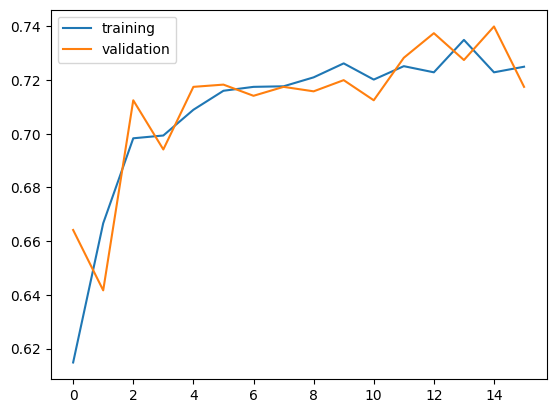

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

The plot suggested that the model stopped training before over-fitting on the training data. This first model (BERT model) returned a validation accuracy of .70. 

## Define and Train Model - Second Model

In the second model, we are going use a preprocessing layer (the same one as the previous one), a 'Small BERT' model, a Dropout layer, and two Dense layers. The Small BERT is smaller in size and thus more efficient for downstream tasks such as text classification. 

In [26]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'

In [27]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [28]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string)
encoder_input = bert_preprocess(text_input)
encoder_output = bert_encoder(encoder_input)

l = tf.keras.layers.Dense(32, activation = 'relu')(encoder_output['pooled_output'])
l = tf.keras.layers.Dropout(0.3)(l)
l = tf.keras.layers.Dense(1, activation = 'sigmoid')(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [29]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [30]:
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 30, 
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.7088
Epoch 1: val_loss improved from 0.53492 to 0.50280, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 37s 227ms/step - loss: 0.5756 - accuracy: 0.7088 - val_loss: 0.5028 - val_accuracy: 0.7717
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.7556
Epoch 2: val_loss improved from 0.50280 to 0.50223, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 33s 221ms/step - loss: 0.5057 - accuracy: 0.7556 - val_loss: 0.5022 - val_accuracy: 0.7675
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.7779
Epoch 3: val_loss improved from 0.50223 to 0.48825, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 33s 220ms/step - loss: 0.4859 - accuracy: 0.7779 - val_loss: 0.4883 - val_accuracy: 0.7758
Epoch 4/30

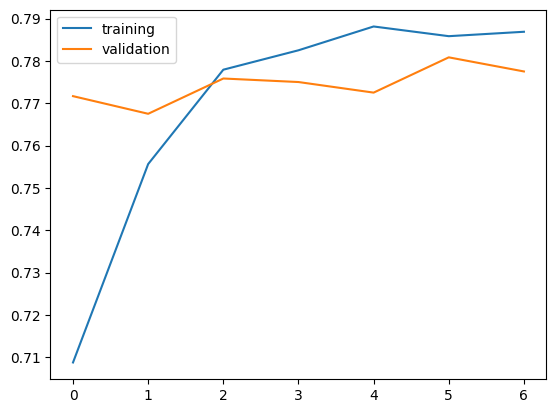

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

The second model returned a validation accuracy of .78. This was a considerable improvement from the first model. The model stopped training although there was no indication of over-fitting, but both training and validation accuracy values were plateauing by the end of the fifth epoch. 

## Define and Train Model - Second Model (2)

In [32]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string)
encoder_input = bert_preprocess(text_input)
encoder_output = bert_encoder(encoder_input)

l = tf.keras.layers.Dense(32, activation = 'relu')(encoder_output['pooled_output'])
l = tf.keras.layers.Dropout(0.3)(l)
l = tf.keras.layers.Dense(16, activation = 'relu')(l)
l = tf.keras.layers.Dropout(0.3)(l)
l = tf.keras.layers.Dense(1, activation = 'sigmoid')(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [33]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [34]:
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 30, 
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.6583
Epoch 1: val_loss did not improve from 0.48259
150/150 [==============================] - 35s 223ms/step - loss: 0.6092 - accuracy: 0.6583 - val_loss: 0.5396 - val_accuracy: 0.7567
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.7412
Epoch 2: val_loss did not improve from 0.48259
150/150 [==============================] - 33s 220ms/step - loss: 0.5387 - accuracy: 0.7412 - val_loss: 0.5020 - val_accuracy: 0.7683
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.7598
Epoch 3: val_loss did not improve from 0.48259
150/150 [==============================] - 33s 219ms/step - loss: 0.5093 - accuracy: 0.7598 - val_loss: 0.4959 - val_accuracy: 0.7708
Epoch 4/30
150/150 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.7710
Epoch 4: val_loss did not improve from 0.48259
150/150 [=================

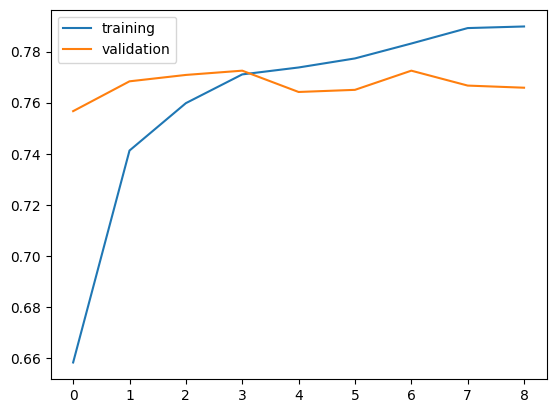

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

The updated model returned a validation accuracy of .76. This was a regression in model performance from the previous one, and validation accuracy started to decrease from the second epoch while training accuracy continued to increase. This is indication that the model started over-fitting since the second epoch. Adding complexity was not the right way to go. 

## Define and Train Model - Third Model

As the second model using the 'Small BERT' model performed considerably better than the first model using the 'bert-based-uncased' model, we are going to continue using the 'Small BERT' model for the new models that follow. This time, we are going to feed the sequential output of the BERT layer into Bidirectional LSTMs instead of immediately feeding the BERT embeddings to a Dense layer as we did in the first two models. 

In [36]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string)
encoder_input = bert_preprocess(text_input)
encoder_output = bert_encoder(encoder_input)

l = tf.keras.layers.Dense(200, activation = 'relu')(encoder_output['sequence_output'])
l = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences = False, dropout = 0.3))(l)
l = tf.keras.layers.Dense(50, activation = 'relu')(l)
l = tf.keras.layers.Dropout(0.3)(l)
l = tf.keras.layers.Dense(1, activation = 'sigmoid')(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [37]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [38]:
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 30, 
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.7583
Epoch 1: val_loss improved from 0.48259 to 0.47462, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 75s 470ms/step - loss: 0.5038 - accuracy: 0.7583 - val_loss: 0.4746 - val_accuracy: 0.7733
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.7973
Epoch 2: val_loss improved from 0.47462 to 0.47207, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 70s 464ms/step - loss: 0.4462 - accuracy: 0.7973 - val_loss: 0.4721 - val_accuracy: 0.7800
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8144
Epoch 3: val_loss improved from 0.47207 to 0.46591, saving model to model/best_performed_model.ckpt
150/150 [==============================] - 69s 464ms/step - loss: 0.4158 - accuracy: 0.8144 - val_loss: 0.4659 - val_accuracy: 0.7875
Epoch 4/30

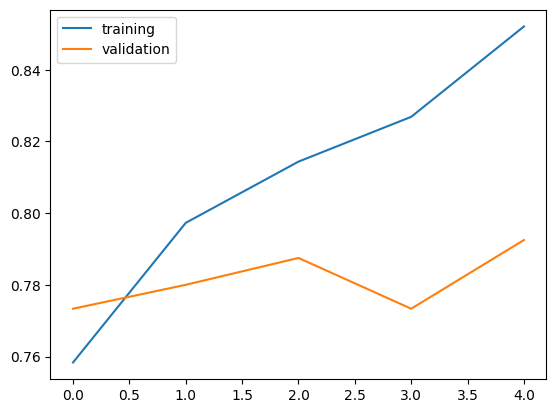

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

The third model returned a validation accuracy of .78. This was a considerable improvement from the first model but not from the second model. We are going to resume working on this task in a new notebook. 

## Prepare for Submission

In [40]:
cleaned_test = clean_text(test)

In [41]:
predictions = model.predict(cleaned_test.text)
pred_list = [np.mean(x) for x in predictions]

102/102 [==============================] - 27s 251ms/step


In [42]:
final_predictions = [(x > 0.5).astype(int) for x in pred_list]

In [43]:
predictions_df = pd.DataFrame(list(zip(test.id, final_predictions)),
                              columns = ['id', 'target'])

In [44]:
predictions_df.to_csv('predictions.csv', index = False)